In [13]:
import os
import sys
sys.path.append("/mnt/home/ubuntu/workspace/code/compositional-representation-learning")

import yaml
import pickle

import numpy as np
import cv2
from torchvision import transforms
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

from pl_modules.BoxEmbeddings.box_utils import bessel_volume
from pl_modules import HierarchicalBoxEmbeddingsVAE
from datasets import get_dataset

In [2]:
config_filepath = "/mnt/home/ubuntu/workspace/code/compositional-representation-learning/configs/HierarchicalBoxEmbeddingsVAE/HierarchicalBoxEmbeddingsVAE_exp_3.yaml"
checkpoint_filepath = "/mnt/home/ubuntu/workspace/experiment_root_dir/HierarchicalBoxEmbeddingsVAE/HierarchicalBoxEmbeddingsVAE_exp_3/HierarchicalBoxEmbeddingsVAE_exp_3___2025-12-28__09-04-12/checkpoints/model-epoch=199.ckpt"

# --- Load Config & Model ---
with open(config_filepath, "r") as file_handle:
    config = yaml.safe_load(file_handle)

model = HierarchicalBoxEmbeddingsVAE.load_from_checkpoint(checkpoint_filepath, config=config)
model.to("cuda")
model.eval()

HierarchicalBoxEmbeddingsVAE(
  (vae): BoxEmbedVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

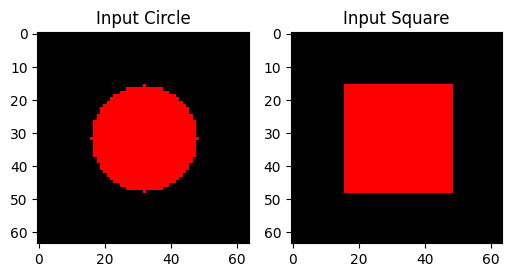

In [3]:
def generate_specific_shape(shape_type, image_size=(64, 64)):
    """Generates a centered red shape."""
    image = np.zeros([image_size[0], image_size[1], 3], dtype=np.uint8)
    
    # Standard Red (BGR in cv2) -> (0, 0, 255)
    color = (255, 0, 0) 
    
    # Fixed center and reasonable size
    center = (image_size[0] // 2, image_size[1] // 2)
    
    if shape_type == "circle":
        radius = image_size[0] // 4
        cv2.circle(image, center, radius, color, -1)
    elif shape_type == "square":
        side_length = image_size[0] // 2
        top_left = (center[0] - side_length // 2, center[1] - side_length // 2)
        bottom_right = (center[0] + side_length // 2, center[1] + side_length // 2)
        cv2.rectangle(image, top_left, bottom_right, color, -1)

    # Transform to Tensor (Matches v0Dataset transform)
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image)

# Generate and Batch
red_circle = generate_specific_shape("circle").unsqueeze(0) # (1, C, H, W)
red_square = generate_specific_shape("square").unsqueeze(0) # (1, C, H, W)

batch_images = torch.cat([red_circle, red_square], dim=0).to("cuda")

# Quick visualization to verify
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(red_circle.squeeze().permute(1,2,0)); plt.title("Input Circle")
plt.subplot(1,2,2); plt.imshow(red_square.squeeze().permute(1,2,0)); plt.title("Input Square")
plt.show()

In [5]:
with torch.no_grad():
    # 1. Run Inference
    output = model({"images": batch_images})

    # 2. Access the separated distributions directly
    patch_dists = output["patch_box_dists"]       # Shape (B*N, D)
    full_dists = output["full_image_box_dists"]   # Shape (B, D)

    # 3. Calculate N (Patches per image) to split the patch list
    B = batch_images.shape[0] # 2
    grid_h, grid_w = config['model']['config']['grid_size']
    N = grid_h * grid_w
    
    # --- Organize Data for Export ---
    export_data = {}
    
    # Image 0: Red Circle
    export_data["circle"] = {
        "full": {
            "min": full_dists.mu_min[0].cpu().numpy(),
            "max": full_dists.mu_max[0].cpu().numpy()
        },
        "patches": {
            # Patches 0 to N-1 belong to the first image
            "min": patch_dists.mu_min[0:N].cpu().numpy(),
            "max": patch_dists.mu_max[0:N].cpu().numpy()
        }
    }
    
    # Image 1: Red Square
    export_data["square"] = {
        "full": {
            "min": full_dists.mu_min[1].cpu().numpy(),
            "max": full_dists.mu_max[1].cpu().numpy()
        },
        "patches": {
            # Patches N to 2N-1 belong to the second image
            "min": patch_dists.mu_min[N:2*N].cpu().numpy(),
            "max": patch_dists.mu_max[N:2*N].cpu().numpy()
        }
    }

# Save to pickle
save_path = "box_viz_data.pkl"
with open(save_path, "wb") as f:
    pickle.dump(export_data, f)

print(f"Embeddings computed and saved to {save_path}")

Embeddings computed and saved to box_viz_data.pkl


In [6]:
export_data

{'circle': {'full': {'min': array([0.9553096 , 0.22375472, 0.41650814], dtype=float32),
   'max': array([1.2008865 , 0.44383508, 0.63698226], dtype=float32)},
  'patches': {'min': array([[0.17030206, 0.1799712 , 0.11490303],
          [0.17030206, 0.1799712 , 0.11490303],
          [0.17030206, 0.1799712 , 0.11490303],
          [0.17030206, 0.1799712 , 0.11490303],
          [0.17030206, 0.1799712 , 0.11490303],
          [0.26897535, 0.00274097, 0.00233098],
          [0.09799775, 0.0042152 , 0.06886653],
          [0.17030206, 0.1799712 , 0.11490303],
          [0.17030206, 0.1799712 , 0.11490303],
          [0.10118938, 0.00497274, 0.00401548],
          [0.06461047, 0.13971768, 0.00334543],
          [0.15584856, 0.17901935, 0.11581695],
          [0.17030206, 0.1799712 , 0.11490303],
          [0.17030206, 0.1799712 , 0.11490303],
          [0.15584856, 0.17901935, 0.11581695],
          [0.17030206, 0.1799712 , 0.11490303]], dtype=float32),
   'max': array([[1.174479 , 1.2477925

In [3]:
def decode_box_distribution(model, box_dist):
    """
    Decodes the 'mean' or canonical representation of a box distribution.
    Input: BoxEmbeddingDistribution (internal params shape: [1, N, D] or [N, D])
    """
    # Handle dimensions (ensure we have [N, D])
    mu_min = box_dist.mu_min
    mu_max = box_dist.mu_max
    
    if mu_min.ndim == 3: # Case (1, N, D)
        mu_min = mu_min.squeeze(0)
        mu_max = mu_max.squeeze(0)
        
    # Concatenate min and max to form the decoder input
    # Shape: (N, D*2)
    z = torch.cat([mu_min, mu_max], dim=-1)
    
    with torch.no_grad():
        reconstructions = model.vae.decode(z)
        
    return reconstructions.cpu()

def plot_grid(images, title, nrow=8):
    """Helper to plot a grid of tensor images"""
    from torchvision.utils import make_grid
    grid = make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
# --- Extract Prior Info ---
with torch.no_grad():
    # 1. Get the box distributions for all levels
    # Returns list: [Level0_BoxDist, Level1_BoxDist]
    prior_dists = model.prior()
    
    level0_dist = prior_dists[0] # The "Patches" / Atomic concepts
    level1_dist = prior_dists[1] # The "Full Images" / Compositions
    
    # 2. Get the adjacency matrix
    # The prior uses gumbel_sigmoid during training, but for inspection
    # we just look at the raw sigmoid probabilities.
    # Shape: (Num_Level1, Num_Level0)
    adjacency_logits = model.prior.adjacency_logits[0] 
    adjacency_weights = torch.sigmoid(adjacency_logits).cpu().numpy()

print(f"Level 0 (Patches) Count: {level0_dist.mu_min.shape[1]}")
print(f"Level 1 (Images) Count: {level1_dist.mu_min.shape[1]}")
print(f"Adjacency Matrix Shape: {adjacency_weights.shape}")

Level 0 (Patches) Count: 16
Level 1 (Images) Count: 4
Adjacency Matrix Shape: (4, 16)


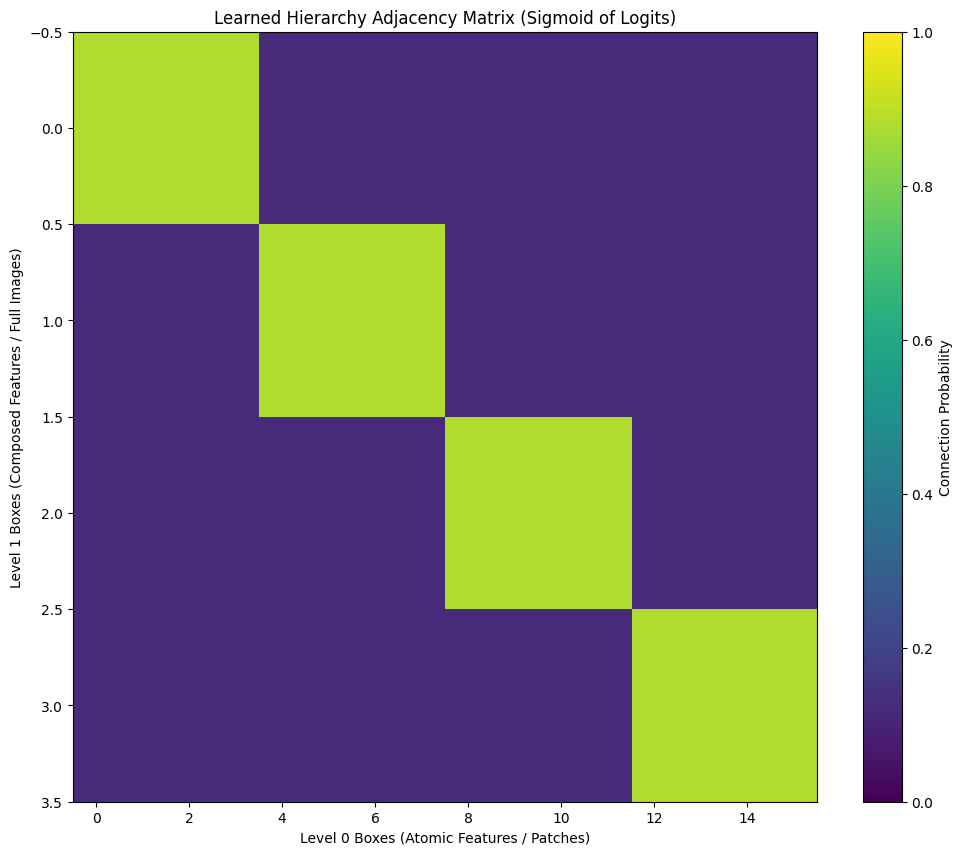

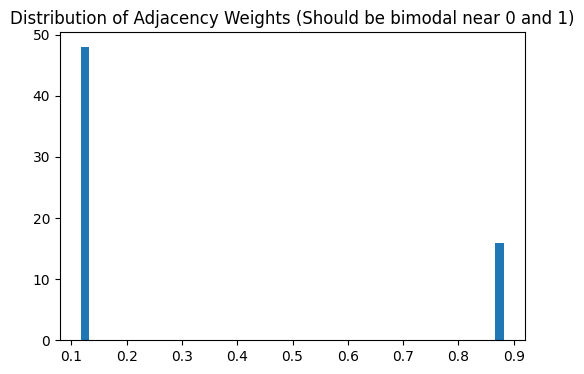

In [5]:
plt.figure(figsize=(12, 10))
plt.imshow(adjacency_weights, aspect='auto', cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label="Connection Probability")
plt.xlabel("Level 0 Boxes (Atomic Features / Patches)")
plt.ylabel("Level 1 Boxes (Composed Features / Full Images)")
plt.title("Learned Hierarchy Adjacency Matrix (Sigmoid of Logits)")
plt.show()

# Histogram of weights to check for binarization
plt.figure(figsize=(6, 4))
plt.hist(adjacency_weights.flatten(), bins=50)
plt.title("Distribution of Adjacency Weights (Should be bimodal near 0 and 1)")
plt.show()

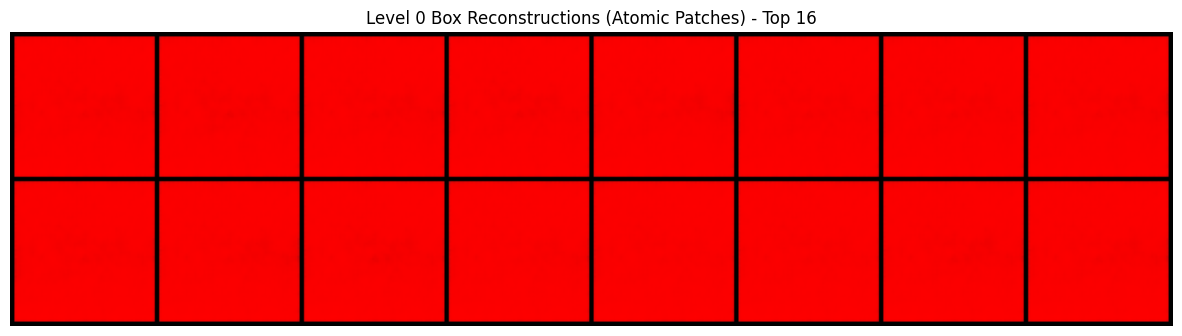

In [6]:
# Decode Level 0 Boxes
recon_l0 = decode_box_distribution(model, level0_dist)

# Plotting the first 64 (or all if less)
n_plot = min(64, recon_l0.shape[0])
plot_grid(recon_l0[:n_plot], f"Level 0 Box Reconstructions (Atomic Patches) - Top {n_plot}")

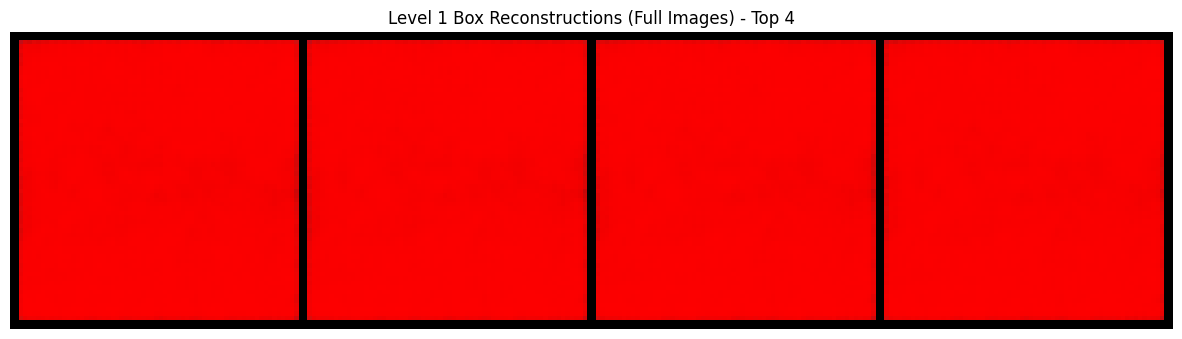

In [7]:
# Decode Level 1 Boxes
recon_l1 = decode_box_distribution(model, level1_dist)

n_plot = min(64, recon_l1.shape[0])
plot_grid(recon_l1[:n_plot], f"Level 1 Box Reconstructions (Full Images) - Top {n_plot}")

In [8]:
def visualize_composition(l1_idx, top_k=5):
    # Get the specific L1 box reconstruction
    l1_img = recon_l1[l1_idx].permute(1, 2, 0).numpy()
    
    # Get weights for this child
    weights = adjacency_weights[l1_idx] # Shape (Num_L0,)
    
    # Get indices of top k parents
    top_indices = np.argsort(weights)[::-1][:top_k]
    top_weights = weights[top_indices]
    
    # Setup Plot
    fig, axes = plt.subplots(1, top_k + 1, figsize=(3 * (top_k + 1), 3))
    
    # Plot Child
    axes[0].imshow(np.clip(l1_img, 0, 1))
    axes[0].set_title(f"L1 Box #{l1_idx}\n(Composition)")
    axes[0].axis('off')
    
    # Plot Parents
    for i, (idx, w) in enumerate(zip(top_indices, top_weights)):
        l0_img = recon_l0[idx].permute(1, 2, 0).numpy()
        ax = axes[i+1]
        ax.imshow(np.clip(l0_img, 0, 1))
        ax.set_title(f"L0 Box #{idx}\nWeight: {w:.2f}")
        ax.axis('off')
        
        # Add a colored border if weight is high (>0.5)
        if w > 0.5:
            for spine in ax.spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)

    plt.suptitle(f"Decomposition of Level 1 Box {l1_idx}", y=1.05)
    plt.tight_layout()
    plt.show()

# Visualize a few random Level 1 boxes
import random
random_indices = random.sample(range(len(recon_l1)), 5)

for idx in random_indices:
    visualize_composition(idx, top_k=6)

ValueError: Sample larger than population or is negative

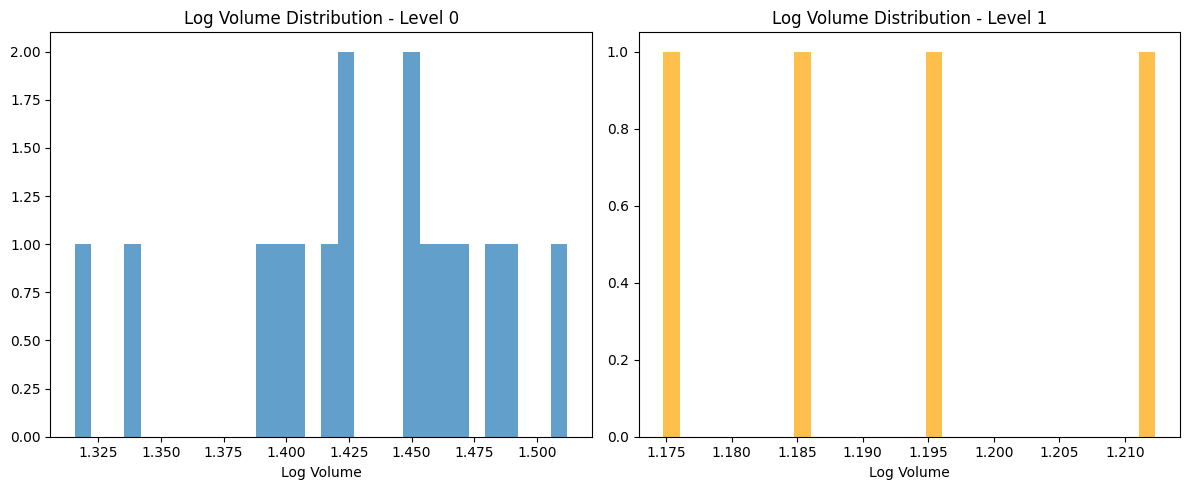

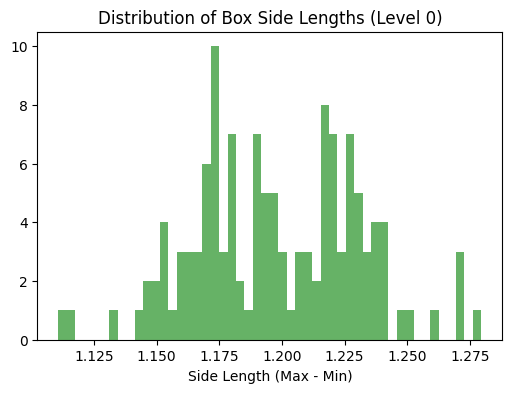

In [15]:
with torch.no_grad():
    # Calculate volumes (log scale)
    vol_l0 = bessel_volume(level0_dist, volume_temp=0.1, log_scale=True).squeeze().cpu().numpy()
    vol_l1 = bessel_volume(level1_dist, volume_temp=0.1, log_scale=True).squeeze().cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(vol_l0, bins=30, alpha=0.7, label='Level 0 (Patches)')
plt.title("Log Volume Distribution - Level 0")
plt.xlabel("Log Volume")

plt.subplot(1, 2, 2)
plt.hist(vol_l1, bins=30, alpha=0.7, color='orange', label='Level 1 (Images)')
plt.title("Log Volume Distribution - Level 1")
plt.xlabel("Log Volume")

plt.tight_layout()
plt.show()

# Check Side lengths (uncertainty)
# Large side lengths = high uncertainty / generic feature
side_lengths_l0 = (level0_dist.mu_max - level0_dist.mu_min).squeeze().detach().cpu().numpy().flatten()
plt.figure(figsize=(6, 4))
plt.hist(side_lengths_l0, bins=50, color='green', alpha=0.6)
plt.title("Distribution of Box Side Lengths (Level 0)")
plt.xlabel("Side Length (Max - Min)")
plt.show()